In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 'normal' if x=='normal' else 'attack')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


In [4]:
df.shape

(125973, 44)

In [5]:
df['srvserrorrate'].value_counts()

,count
srvserrorrate,
0.00,88754
1.00,34874
0.50,432
0.33,273
0.25,233
...,...
0.57,1
0.74,1
0.65,1


In [6]:
df['srvserrorrate'].nunique()

86

<Axes: xlabel='srvserrorrate', ylabel='Density'>

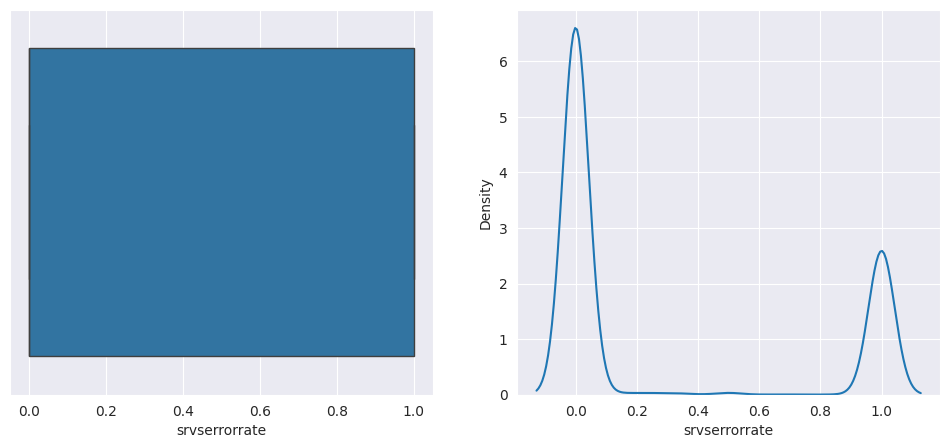

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='srvserrorrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='srvserrorrate')

In [8]:
pd.DataFrame(df['srvserrorrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
srvserrorrate,125973.0,0.282485,0.447022,0.0,0.0,0.0,1.0,1.0


In [9]:
np.percentile(df['srvserrorrate'],75),np.percentile(df['srvserrorrate'],50),np.percentile(df['srvserrorrate'],25)

(1.0, 0.0, 0.0)

In [10]:
IQR = np.percentile(df['srvserrorrate'],75)-np.percentile(df['srvserrorrate'],25)
ulimit = np.percentile(df['srvserrorrate'],75) + 1.5*IQR
ulimit

2.5

In [11]:
not_outlier = df[df['srvserrorrate'] <= ulimit]
is_outlier = df[df['srvserrorrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(100.0, 0.0)

In [12]:
# checking attacks above 50% error
df[df['srvserrorrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
attack,34836
normal,728


In [13]:
# checking attacks below 50% error
df[df['srvserrorrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
normal,66615
attack,23794


In [14]:
srverdf = df.copy()
srverdf['login_failed'] = srverdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
srverdf['is_hot'] = srverdf['hot'].apply(lambda x: 1 if x > 0 else 0)
srverdf['is_compromised'] = srverdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
srverdf['nroot'] = srverdf['numroot'].apply(lambda x: 1 if x > 0 else 0)
srverdf['fc'] = srverdf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
srverdf['attk'] = srverdf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [15]:
# divide data into 4 bins each bin having 0.25%
srverdf['bins'] = None
for i in range(len(srverdf)):
  ser = srverdf.loc[i,'srvserrorrate']
  if ser < 0.25:
    srverdf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    srverdf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    srverdf.loc[i,'bins'] = 3
  else:
    srverdf.loc[i,'bins'] = 4

In [16]:
srverdf['bins'].value_counts()

,count
bins,
1,89819
4,35046
2,590
3,518


In [17]:
# number of attacks in each bin
pd.pivot_table(data=srverdf,index='bins',columns='is_attack',values='attk',aggfunc='count',margins=True)

is_attack,attack,normal,All
bins,,,
1,23762,66057,89819
2,32,558,590
3,147,371,518
4,34689,357,35046
All,58630,67343,125973


In [18]:
pd.pivot_table(data=srverdf,index='bins',columns='is_attack',values='attk',aggfunc='sum')

is_attack,attack,normal
bins,,
1,23762,0
2,32,0
3,147,0
4,34689,0


In [19]:
# type of attack in each bin : bin 1
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False)

bins,1,2,3,4
attack,,,,
neptune,6898.0,27.0,43.0,34246.0
ipsweep,3599.0,NaN,NaN,NaN
satan,3535.0,NaN,NaN,98.0
portsweep,2787.0,NaN,90.0,54.0
smurf,2646.0,NaN,NaN,NaN
nmap,1228.0,NaN,NaN,265.0
back,944.0,5.0,7.0,NaN
teardrop,892.0,NaN,NaN,NaN
warezclient,887.0,NaN,1.0,2.0


In [20]:
# type of attack in each bin : bin 2
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(3)

bins,1,2,3,4
attack,,,,
neptune,6898.0,27.0,43.0,34246.0
back,944.0,5.0,7.0,NaN
buffer_overflow,30.0,NaN,NaN,NaN


In [21]:
# type of attack in each bin : bin 3
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(8)

bins,1,2,3,4
attack,,,,
portsweep,2787.0,NaN,90.0,54.0
neptune,6898.0,27.0,43.0,34246.0
back,944.0,5.0,7.0,NaN
imap,2.0,NaN,4.0,5.0
guess_passwd,50.0,NaN,2.0,1.0
warezclient,887.0,NaN,1.0,2.0
buffer_overflow,30.0,NaN,NaN,NaN
ftp_write,8.0,NaN,NaN,NaN


In [22]:
# type of attack in each bin : bin 4
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,6898.0,27.0,43.0,34246.0
nmap,1228.0,NaN,NaN,265.0
satan,3535.0,NaN,NaN,98.0
portsweep,2787.0,NaN,90.0,54.0
land,NaN,NaN,NaN,18.0
imap,2.0,NaN,4.0,5.0
warezclient,887.0,NaN,1.0,2.0
guess_passwd,50.0,NaN,2.0,1.0
back,944.0,5.0,7.0,NaN


In [23]:
# type of service in each bin : bin 1
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,7786.0,NaN,69.0,13016.0
eco_i,4089.0,NaN,NaN,NaN
ecr_i,2887.0,NaN,NaN,NaN
other,1644.0,NaN,NaN,111.0
http,1162.0,30.0,37.0,1060.0
ftp_data,741.0,NaN,4.0,1131.0
ftp,442.0,NaN,1.0,393.0
telnet,195.0,NaN,3.0,1238.0
Z39_50,186.0,NaN,NaN,676.0


In [24]:
# type of service in each bin : bin 2
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(5)

bins,1,2,3,4
service,,,,
http,1162.0,30.0,37.0,1060.0
smtp,80.0,2.0,11.0,191.0
IRC,1.0,NaN,NaN,NaN
X11,4.0,NaN,NaN,2.0
Z39_50,186.0,NaN,NaN,676.0


In [25]:
# type of service in each bin : bin 3
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,7786.0,NaN,69.0,13016.0
http,1162.0,30.0,37.0,1060.0
smtp,80.0,2.0,11.0,191.0
finger,117.0,NaN,4.0,1101.0
ftp_data,741.0,NaN,4.0,1131.0
imap4,142.0,NaN,4.0,498.0
telnet,195.0,NaN,3.0,1238.0
ctf,133.0,NaN,1.0,429.0
netstat,58.0,NaN,1.0,301.0


In [26]:
# type of service in each bin : bin 4
pd.pivot_table(data=srverdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,7786.0,NaN,69.0,13016.0
telnet,195.0,NaN,3.0,1238.0
ftp_data,741.0,NaN,4.0,1131.0
finger,117.0,NaN,4.0,1101.0
http,1162.0,30.0,37.0,1060.0
Z39_50,186.0,NaN,NaN,676.0
uucp,176.0,NaN,NaN,604.0
courier,137.0,NaN,NaN,597.0
auth,151.0,NaN,NaN,568.0


In [27]:
# retrieve original number of connections under this service under this host
srverdf['S0123_flag_count'] = srverdf['srvcount']*srverdf['srvserrorrate']

In [28]:
srverdf['S0123_flag_count'].value_counts()

,count
S0123_flag_count,
0.00,88754
1.00,3609
2.00,2009
20.00,1908
3.00,1837
...,...
3.91,1
0.90,1
9.96,1


<Axes: xlabel='S0123_flag_count'>

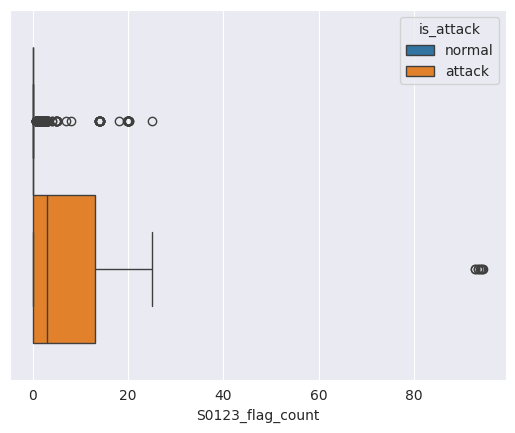

In [29]:
sns.boxplot(data=srverdf,x='S0123_flag_count',hue='is_attack')

In [30]:
pd.DataFrame(srverdf['S0123_flag_count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
S0123_flag_count,125973.0,3.049338,6.06351,0.0,0.0,0.0,2.0,94.54


In [31]:
# divide data ino bins based on number of active flags for the host: again first and last 25% have most attacks
srverdf['cbins'] = None
for i in range(len(srverdf)):
  ser = srverdf.loc[i,'S0123_flag_count']
  if ser < 25:
    srverdf.loc[i,'cbins'] = 1
  elif ser >= 25 and ser < 50:
    srverdf.loc[i,'cbins'] = 2
  elif ser >= 50 and ser < 75:
    srverdf.loc[i,'cbins'] = 3
  else:
    srverdf.loc[i,'cbins'] = 4

In [32]:
srverdf['cbins'].value_counts()

,count
cbins,
1,125459
2,506
4,8


In [33]:
# no values under bin3; bin 2 and 4 have all attacks
pd.pivot_table(data=srverdf,index='cbins',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbins,,
1,58116.0,67343.0
2,506.0,NaN
4,8.0,NaN


In [34]:
# detailed sub binning under bin 1, find the value after which attacks rise
srverdf['cbin2'] = None
for i in range(len(srverdf)):
  ser = srverdf.loc[i,'S0123_flag_count']
  if ser < 5:
    srverdf.loc[i,'cbin2'] = 1
  elif ser >= 5 and ser < 10:
    srverdf.loc[i,'cbin2'] = 2
  elif ser >= 10 and ser < 15:
    srverdf.loc[i,'cbin2'] = 3
  elif ser >= 15 and ser < 20:
    srverdf.loc[i,'cbin2'] = 4
  else:
    srverdf.loc[i,'cbin2'] = 5

In [35]:
srverdf['cbin2'].value_counts()

,count
cbin2,
1,99187
4,7825
2,7823
3,7019
5,4119


In [36]:
# After bin1, after 5 requests in last 2 seconds on same service on same host, attack chances increase
pd.pivot_table(data=srverdf,index='cbin2',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbin2,,
1,31889,67298
2,7817,6
3,7007,12
4,7807,18
5,4110,9


In [37]:
# services with most requests in the dataset across different hosts
srverdf.groupby('service')['S0123_flag_count'].sum().sort_values(ascending=False).head(10)

,S0123_flag_count
service,
private,137070.25
http,14821.75
telnet,13319.00
ftp_data,12417.61
finger,11831.10
Z39_50,7531.00
iso_tsap,6713.00
uucp,6601.00
uucp_path,6407.00


In [38]:
# service ber number of requests bin: bin 1
pd.pivot_table(data=srverdf,index='service',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(1,ascending=False)

cbins,1,2,4
service,,,
http,40331.0,7.0,NaN
private,21691.0,162.0,NaN
domain_u,9043.0,NaN,NaN
smtp,7312.0,1.0,NaN
ftp_data,6852.0,8.0,NaN
...,...,...,...
tftp_u,3.0,NaN,NaN
http_8001,2.0,NaN,NaN
harvest,2.0,NaN,NaN


In [39]:
# service ber number of requests bin: bin 2
pd.pivot_table(data=srverdf,index='service',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(2,ascending=False).head(20)

cbins,1,2,4
service,,,
private,21691.0,162.0,NaN
Z39_50,853.0,9.0,NaN
finger,1758.0,9.0,NaN
link,466.0,9.0,NaN
netbios_ssn,353.0,9.0,NaN
nntp,287.0,9.0,NaN
sunrpc,372.0,9.0,NaN
uucp_path,680.0,9.0,NaN
vmnet,608.0,9.0,NaN


In [40]:
# service ber number of requests bin: bin 4
pd.pivot_table(data=srverdf,index='service',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(4,ascending=False).head(2)

cbins,1,2,4
service,,,
imap4,632.0,7.0,8.0
IRC,187.0,NaN,NaN


In [45]:
# attacks ber number of requests bin: bin 1
pd.pivot_table(data=srverdf,index='attack',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(1,ascending=False).head(10)

cbins,1,2,4
attack,,,
normal,67343.0,NaN,NaN
neptune,40708.0,506.0,NaN
satan,3633.0,NaN,NaN
ipsweep,3599.0,NaN,NaN
portsweep,2931.0,NaN,NaN
smurf,2646.0,NaN,NaN
nmap,1493.0,NaN,NaN
back,956.0,NaN,NaN
teardrop,892.0,NaN,NaN


In [47]:
# attacks ber number of requests bin: bin 2
pd.pivot_table(data=srverdf,index='attack',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(2,ascending=False).head(2)

cbins,1,2,4
attack,,,
neptune,40708.0,506.0,NaN
back,956.0,NaN,NaN


In [49]:
# attacks ber number of requests bin: bin 4
pd.pivot_table(data=srverdf,index='attack',columns='cbins',values='S0123_flag_count',aggfunc='count').sort_values(4,ascending=False).head(2)

cbins,1,2,4
attack,,,
imap,3.0,NaN,8.0
back,956.0,NaN,NaN


In [51]:
df['rerrorrate'].value_counts()

,count
rerrorrate,
0.00,109783
1.00,12874
0.90,269
0.92,216
0.93,210
...,...
0.65,1
0.63,1
0.18,1


In [52]:
df['rerrorrate'].nunique()

82

<Axes: xlabel='rerrorrate', ylabel='Density'>

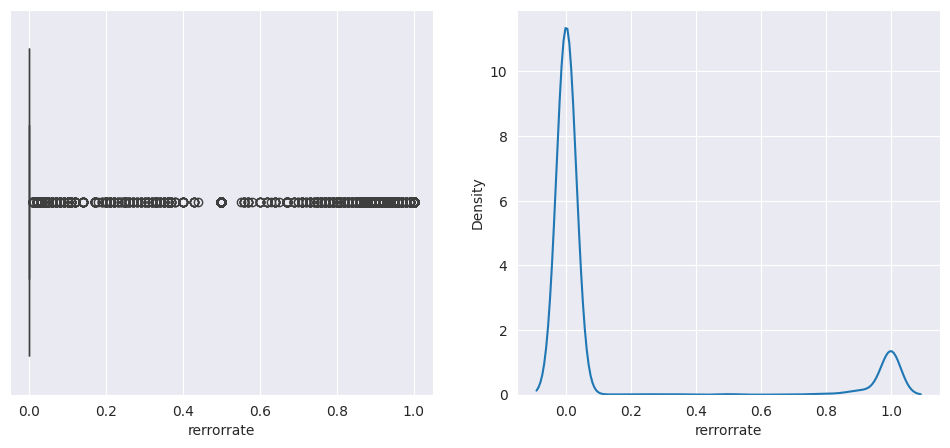

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='rerrorrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='rerrorrate')

In [54]:
pd.DataFrame(df['rerrorrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
rerrorrate,125973.0,0.119958,0.320436,0.0,0.0,0.0,0.0,1.0


In [55]:
np.percentile(df['rerrorrate'],75),np.percentile(df['rerrorrate'],50),np.percentile(df['rerrorrate'],25)

(0.0, 0.0, 0.0)

In [58]:
IQR = np.percentile(df['rerrorrate'],75)-np.percentile(df['rerrorrate'],25)
ulimit = np.percentile(df['rerrorrate'],75) + 1.5*IQR
ulimit

0.0

In [59]:
not_outlier = df[df['rerrorrate'] <= ulimit]
is_outlier = df[df['rerrorrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(87.14803965929208, 12.85196034070793)

In [60]:
not_outlier['is_attack'].value_counts()

,count
is_attack,
normal,64146
attack,45637


In [61]:
is_outlier['is_attack'].value_counts()

,count
is_attack,
attack,12993
normal,3197


In [62]:
# attacks when greater than 50%
df[df['rerrorrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
attack,12309
normal,3028


In [63]:
# attacks when less than 50%
df[df['rerrorrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
normal,64315
attack,46321


In [64]:
rerdf = df.copy()
rerdf['login_failed'] = rerdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
rerdf['is_hot'] = rerdf['hot'].apply(lambda x: 1 if x > 0 else 0)
rerdf['is_compromised'] = rerdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
rerdf['nroot'] = rerdf['numroot'].apply(lambda x: 1 if x > 0 else 0)
rerdf['fc'] = rerdf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
rerdf['attk'] = rerdf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [65]:
# bin the data into 4 groups
rerdf['bins'] = None
for i in range(len(rerdf)):
  ser = rerdf.loc[i,'rerrorrate']
  if ser < 0.25:
    rerdf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    rerdf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    rerdf.loc[i,'bins'] = 3
  else:
    rerdf.loc[i,'bins'] = 4

In [66]:
rerdf['bins'].value_counts()

,count
bins,
1,110369
4,15067
3,270
2,267


In [67]:
# number of attacks across each bin
pd.pivot_table(data=rerdf,index='bins',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
bins,,
1,46106,64263
2,215,52
3,124,146
4,12185,2882


In [69]:
# type of attack in each bin : bin 1
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,34308.0,12.0,6.0,6888.0
ipsweep,3172.0,NaN,1.0,426.0
smurf,2646.0,NaN,NaN,NaN
satan,1494.0,21.0,31.0,2087.0
nmap,1493.0,NaN,NaN,NaN
teardrop,892.0,NaN,NaN,NaN
warezclient,887.0,NaN,1.0,2.0
back,801.0,96.0,45.0,14.0
pod,201.0,NaN,NaN,NaN


In [71]:
# type of attack in each bin : bin 2
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

bins,1,2,3,4
attack,,,,
back,801.0,96.0,45.0,14.0
portsweep,89.0,86.0,36.0,2720.0
satan,1494.0,21.0,31.0,2087.0
neptune,34308.0,12.0,6.0,6888.0
buffer_overflow,29.0,NaN,1.0,NaN


In [75]:
# type of attack in each bin : bin 3
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
back,801.0,96.0,45.0,14.0
portsweep,89.0,86.0,36.0,2720.0
satan,1494.0,21.0,31.0,2087.0
neptune,34308.0,12.0,6.0,6888.0
guess_passwd,3.0,NaN,2.0,48.0
buffer_overflow,29.0,NaN,1.0,NaN
ipsweep,3172.0,NaN,1.0,426.0
land,17.0,NaN,1.0,NaN
warezclient,887.0,NaN,1.0,2.0


In [76]:
# type of attack in each bin : bin 4
pd.pivot_table(data=rerdf[rerdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,34308.0,12.0,6.0,6888.0
portsweep,89.0,86.0,36.0,2720.0
satan,1494.0,21.0,31.0,2087.0
ipsweep,3172.0,NaN,1.0,426.0
guess_passwd,3.0,NaN,2.0,48.0
back,801.0,96.0,45.0,14.0
warezclient,887.0,NaN,1.0,2.0
buffer_overflow,29.0,NaN,1.0,NaN
ftp_write,8.0,NaN,NaN,NaN


In [78]:
# detailed sub binning under bin 1, find the value after which attacks rise
rerdf['cbin2'] = None
for i in range(len(rerdf)):
  ser = rerdf.loc[i,'rerrorrate']
  if ser < 0.05:
    rerdf.loc[i,'cbin2'] = 1
  elif ser >= 0.05 and ser < 0.1:
    rerdf.loc[i,'cbin2'] = 2
  elif ser >= 0.1 and ser < 0.15:
    rerdf.loc[i,'cbin2'] = 3
  elif ser >= 0.15 and ser < 0.20:
    rerdf.loc[i,'cbin2'] = 4
  elif ser >= 0.20 and ser < 0.25:
    rerdf.loc[i,'cbin2'] = 5
  else:
    rerdf.loc[i,'cbin2'] = 6

In [79]:
# number of attacks across each sub bin
pd.pivot_table(data=rerdf,index='cbin2',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbin2,,
1,45907,64168
2,79,39
3,21,30
4,26,11
5,73,15
6,12524,3080


In [83]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

cbin2,1,2,3,4,5,6
attack,,,,,,
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
ipsweep,3172.0,NaN,NaN,NaN,NaN,427.0
smurf,2646.0,NaN,NaN,NaN,NaN,NaN
satan,1493.0,NaN,NaN,1.0,NaN,2139.0
nmap,1493.0,NaN,NaN,NaN,NaN,NaN
teardrop,890.0,2.0,NaN,NaN,NaN,NaN
warezclient,887.0,NaN,NaN,NaN,NaN,3.0
back,742.0,2.0,5.0,16.0,36.0,155.0


In [85]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
back,742.0,2.0,5.0,16.0,36.0,155.0
teardrop,890.0,2.0,NaN,NaN,NaN,NaN
portsweep,54.0,1.0,NaN,3.0,31.0,2842.0


In [86]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(3,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
back,742.0,2.0,5.0,16.0,36.0,155.0
buffer_overflow,29.0,NaN,NaN,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN,NaN,NaN


In [87]:
# type of attacks across each sub bin
pd.pivot_table(data=rerdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(4,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
back,742.0,2.0,5.0,16.0,36.0,155.0
normal,64168.0,39.0,30.0,11.0,15.0,3080.0
neptune,34206.0,74.0,16.0,6.0,6.0,6906.0
portsweep,54.0,1.0,NaN,3.0,31.0,2842.0
satan,1493.0,NaN,NaN,1.0,NaN,2139.0


In [88]:
df['srvrerrorrate'].value_counts()

,count
srvrerrorrate,
0.00,109767
1.00,14827
0.50,244
0.33,160
0.25,114
...,...
0.90,1
0.55,1
0.18,1


In [89]:
df['srvrerrorrate'].nunique()

62

<Axes: xlabel='srvrerrorrate', ylabel='Density'>

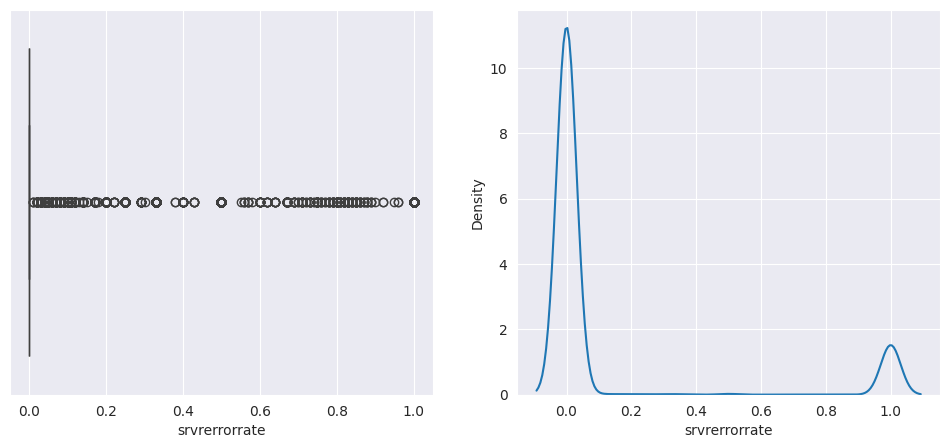

In [96]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='srvrerrorrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='srvrerrorrate')

In [97]:
pd.DataFrame(df['srvrerrorrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
srvrerrorrate,125973.0,0.121183,0.323647,0.0,0.0,0.0,0.0,1.0


In [98]:
np.percentile(df['srvrerrorrate'],75),np.percentile(df['srvrerrorrate'],50),np.percentile(df['srvrerrorrate'],25)

(0.0, 0.0, 0.0)

In [99]:
IQR = np.percentile(df['srvrerrorrate'],75)-np.percentile(df['srvrerrorrate'],25)
ulimit = np.percentile(df['srvrerrorrate'],75) + 1.5*IQR
ulimit

0.0

In [101]:
not_outlier = df[df['srvrerrorrate'] <= ulimit]
is_outlier = df[df['srvrerrorrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(87.13533852492202, 12.864661475077993)

In [102]:
# checking attacks above 50% error
df[df['srvrerrorrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
attack,12250
normal,3030


In [103]:
# checking attacks below 50% error
df[df['srvrerrorrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
normal,64313
attack,46380


In [104]:
srverrdf = df.copy()
srverrdf['login_failed'] = srverrdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
srverrdf['is_hot'] = srverrdf['hot'].apply(lambda x: 1 if x > 0 else 0)
srverrdf['is_compromised'] = srverrdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
srverrdf['nroot'] = srverrdf['numroot'].apply(lambda x: 1 if x > 0 else 0)
srverrdf['fc'] = srverrdf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
srverrdf['attk'] = srverrdf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [105]:
# divide data into 4 bins each bin having 0.25%
srverrdf['bins'] = None
for i in range(len(srverrdf)):
  ser = srverrdf.loc[i,'srvrerrorrate']
  if ser < 0.25:
    srverrdf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    srverrdf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    srverrdf.loc[i,'bins'] = 3
  else:
    srverrdf.loc[i,'bins'] = 4

In [106]:
srverrdf['bins'].value_counts()

,count
bins,
1,110373
4,14939
3,341
2,320


In [107]:
# number of attacks in each bin
pd.pivot_table(data=srverrdf,index='bins',columns='is_attack',values='attk',aggfunc='count',margins=True)

is_attack,attack,normal,All
bins,,,
1,46170,64203,110373
2,210,110,320
3,158,183,341
4,12092,2847,14939
All,58630,67343,125973


In [109]:
# type of attack in each bin : bin 1
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,34312.0,10.0,7.0,6885.0
ipsweep,3174.0,NaN,NaN,425.0
smurf,2646.0,NaN,NaN,NaN
satan,1657.0,NaN,1.0,1975.0
nmap,1493.0,NaN,NaN,NaN
teardrop,892.0,NaN,NaN,NaN
warezclient,888.0,NaN,NaN,2.0
back,685.0,168.0,87.0,16.0
pod,201.0,NaN,NaN,NaN


In [111]:
# type of attack in each bin : bin 2
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

bins,1,2,3,4
attack,,,,
back,685.0,168.0,87.0,16.0
portsweep,99.0,32.0,60.0,2740.0
neptune,34312.0,10.0,7.0,6885.0
buffer_overflow,29.0,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN


In [112]:
# type of attack in each bin : bin 3
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(8)

bins,1,2,3,4
attack,,,,
back,685.0,168.0,87.0,16.0
portsweep,99.0,32.0,60.0,2740.0
neptune,34312.0,10.0,7.0,6885.0
guess_passwd,3.0,NaN,2.0,48.0
phf,3.0,NaN,1.0,NaN
satan,1657.0,NaN,1.0,1975.0
buffer_overflow,29.0,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN


In [114]:
# type of attack in each bin : bin 4
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,34312.0,10.0,7.0,6885.0
portsweep,99.0,32.0,60.0,2740.0
satan,1657.0,NaN,1.0,1975.0
ipsweep,3174.0,NaN,NaN,425.0
guess_passwd,3.0,NaN,2.0,48.0
back,685.0,168.0,87.0,16.0
warezclient,888.0,NaN,NaN,2.0
buffer_overflow,29.0,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN


In [115]:
# type of service in each bin : bin 1
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,15362.0,25.0,44.0,5440.0
eco_i,4089.0,NaN,NaN,NaN
ecr_i,2887.0,NaN,NaN,NaN
http,1803.0,178.0,92.0,216.0
ftp_data,1747.0,NaN,1.0,128.0
telnet,1289.0,NaN,4.0,143.0
finger,1141.0,3.0,2.0,76.0
ftp,715.0,NaN,1.0,120.0
Z39_50,676.0,NaN,NaN,186.0


In [116]:
# type of service in each bin : bin 2
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(5)

bins,1,2,3,4
service,,,,
http,1803.0,178.0,92.0,216.0
private,15362.0,25.0,44.0,5440.0
finger,1141.0,3.0,2.0,76.0
ctf,429.0,1.0,NaN,133.0
gopher,395.0,1.0,NaN,122.0


In [117]:
# type of service in each bin : bin 3
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(10)

bins,1,2,3,4
service,,,,
http,1803.0,178.0,92.0,216.0
private,15362.0,25.0,44.0,5440.0
telnet,1289.0,NaN,4.0,143.0
smtp,231.0,NaN,4.0,49.0
finger,1141.0,3.0,2.0,76.0
daytime,428.0,NaN,1.0,92.0
time,452.0,NaN,1.0,125.0
systat,377.0,NaN,1.0,99.0
ssh,241.0,NaN,1.0,64.0


In [118]:
# type of service in each bin : bin 4
pd.pivot_table(data=srverrdf[srverdf['attack'] != 'normal'],index='service',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,15362.0,25.0,44.0,5440.0
other,355.0,NaN,NaN,1400.0
http,1803.0,178.0,92.0,216.0
Z39_50,676.0,NaN,NaN,186.0
uucp,607.0,NaN,NaN,173.0
bgp,547.0,NaN,NaN,163.0
uucp_path,542.0,NaN,NaN,147.0
auth,574.0,NaN,NaN,145.0
whois,549.0,NaN,1.0,143.0


In [119]:
# detailed sub binning under bin 1, find the value after which attacks rise
srverrdf['cbin2'] = None
for i in range(len(srverrdf)):
  ser = srverrdf.loc[i,'srvrerrorrate']
  if ser < 0.05:
    srverrdf.loc[i,'cbin2'] = 1
  elif ser >= 0.05 and ser < 0.1:
    srverrdf.loc[i,'cbin2'] = 2
  elif ser >= 0.1 and ser < 0.15:
    srverrdf.loc[i,'cbin2'] = 3
  elif ser >= 0.15 and ser < 0.20:
    srverrdf.loc[i,'cbin2'] = 4
  elif ser >= 0.20 and ser < 0.25:
    srverrdf.loc[i,'cbin2'] = 5
  else:
    srverrdf.loc[i,'cbin2'] = 6

In [120]:
srverrdf['cbin2'].value_counts()

,count
cbin2,
1,109907
6,15600
2,166
3,127
5,98
4,75


In [121]:
# type of attacks across each sub bin
pd.pivot_table(data=srverrdf,index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

cbin2,1,2,3,4,5,6
attack,,,,,,
normal,63897.0,124.0,100.0,37.0,45.0,3140.0
neptune,34243.0,41.0,19.0,4.0,5.0,6902.0
ipsweep,3173.0,NaN,NaN,1.0,NaN,425.0
smurf,2646.0,NaN,NaN,NaN,NaN,NaN
satan,1657.0,NaN,NaN,NaN,NaN,1976.0
nmap,1493.0,NaN,NaN,NaN,NaN,NaN
teardrop,892.0,NaN,NaN,NaN,NaN,NaN
warezclient,888.0,NaN,NaN,NaN,NaN,2.0
back,596.0,1.0,8.0,32.0,48.0,271.0


In [127]:
# type of attacks across each sub bin
pd.pivot_table(data=srverrdf[srverrdf['attack']!='normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,34243.0,41.0,19.0,4.0,5.0,6902.0
back,596.0,1.0,8.0,32.0,48.0,271.0
buffer_overflow,29.0,NaN,NaN,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN,NaN,NaN
guess_passwd,3.0,NaN,NaN,NaN,NaN,50.0


In [128]:
# type of attacks across each sub bin
pd.pivot_table(data=srverrdf[srverrdf['attack']!='normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(3,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,34243.0,41.0,19.0,4.0,5.0,6902.0
back,596.0,1.0,8.0,32.0,48.0,271.0
buffer_overflow,29.0,NaN,NaN,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN,NaN,NaN
guess_passwd,3.0,NaN,NaN,NaN,NaN,50.0


In [129]:
# type of attacks across each sub bin
pd.pivot_table(data=srverrdf[srverrdf['attack']!='normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(4,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
back,596.0,1.0,8.0,32.0,48.0,271.0
neptune,34243.0,41.0,19.0,4.0,5.0,6902.0
ipsweep,3173.0,NaN,NaN,1.0,NaN,425.0
portsweep,98.0,NaN,NaN,1.0,NaN,2832.0
buffer_overflow,29.0,NaN,NaN,NaN,NaN,1.0


In [130]:
# type of attacks across each sub bin
pd.pivot_table(data=srverrdf[srverrdf['attack']!='normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(5,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
back,596.0,1.0,8.0,32.0,48.0,271.0
neptune,34243.0,41.0,19.0,4.0,5.0,6902.0
buffer_overflow,29.0,NaN,NaN,NaN,NaN,1.0
ftp_write,8.0,NaN,NaN,NaN,NaN,NaN
guess_passwd,3.0,NaN,NaN,NaN,NaN,50.0


In [131]:
df['samesrvrate'].value_counts()

,count
samesrvrate,
1.00,76812
0.01,4027
0.02,3616
0.03,3503
0.07,3438
...,...
0.82,6
0.68,6
0.81,4


In [132]:
df['samesrvrate'].nunique()

101

<Axes: xlabel='samesrvrate', ylabel='Density'>

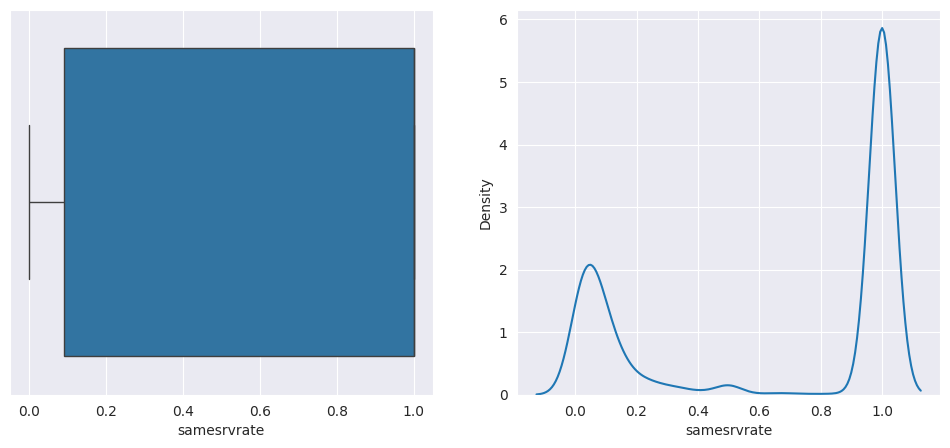

In [133]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='samesrvrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='samesrvrate')

In [134]:
pd.DataFrame(df['samesrvrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
samesrvrate,125973.0,0.660928,0.439623,0.0,0.09,1.0,1.0,1.0


In [135]:
np.percentile(df['samesrvrate'],75),np.percentile(df['samesrvrate'],50),np.percentile(df['samesrvrate'],25)

(1.0, 1.0, 0.09)

In [136]:
IQR = np.percentile(df['samesrvrate'],75)-np.percentile(df['samesrvrate'],25)
ulimit = np.percentile(df['samesrvrate'],75) + 1.5*IQR
ulimit

2.365

In [137]:
not_outlier = df[df['samesrvrate'] <= ulimit]
is_outlier = df[df['samesrvrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(100.0, 0.0)

In [138]:
# attacks when greater than 50%
df[df['samesrvrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
normal,65563
attack,14890


In [139]:
# attacks when greater than 50%
df[df['samesrvrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
attack,43740
normal,1780


In [144]:
ssdf = df.copy()
ssdf['login_failed'] = ssdf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
ssdf['is_hot'] = ssdf['hot'].apply(lambda x: 1 if x > 0 else 0)
ssdf['is_compromised'] = ssdf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
ssdf['nroot'] = ssdf['numroot'].apply(lambda x: 1 if x > 0 else 0)
ssdf['fc'] = ssdf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
ssdf['attk'] = ssdf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [145]:
# bin the data into 4 groups
ssdf['bins'] = None
for i in range(len(ssdf)):
  ser = ssdf.loc[i,'samesrvrate']
  if ser < 0.25:
    ssdf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    ssdf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    ssdf.loc[i,'bins'] = 3
  else:
    ssdf.loc[i,'bins'] = 4

In [146]:
ssdf['bins'].value_counts()

,count
bins,
4,78181
1,42258
2,3262
3,2272


In [147]:
# number of attacks across each sub bin
pd.pivot_table(data=ssdf,index='bins',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
bins,,
1,41129,1129
2,2611,651
3,1011,1261
4,13879,64302


In [148]:
# type of attacks across each sub bin
pd.pivot_table(data=ssdf,index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,37952.0,2249.0,453.0,560.0
satan,2687.0,280.0,189.0,477.0
normal,1129.0,651.0,1261.0,64302.0
portsweep,452.0,13.0,340.0,2126.0
teardrop,31.0,62.0,1.0,798.0
buffer_overflow,2.0,NaN,1.0,27.0
ipsweep,2.0,NaN,7.0,3590.0
nmap,2.0,6.0,9.0,1476.0
land,1.0,1.0,NaN,16.0


In [150]:
# type of attacks across each sub bin
pd.pivot_table(data=ssdf,index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,37952.0,2249.0,453.0,560.0
normal,1129.0,651.0,1261.0,64302.0
satan,2687.0,280.0,189.0,477.0
teardrop,31.0,62.0,1.0,798.0
portsweep,452.0,13.0,340.0,2126.0
nmap,2.0,6.0,9.0,1476.0
land,1.0,1.0,NaN,16.0
back,NaN,NaN,2.0,954.0
buffer_overflow,2.0,NaN,1.0,27.0


In [151]:
# type of attacks across each sub bin
pd.pivot_table(data=ssdf,index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
normal,1129.0,651.0,1261.0,64302.0
neptune,37952.0,2249.0,453.0,560.0
portsweep,452.0,13.0,340.0,2126.0
satan,2687.0,280.0,189.0,477.0
nmap,2.0,6.0,9.0,1476.0
ipsweep,2.0,NaN,7.0,3590.0
warezclient,NaN,NaN,7.0,883.0
back,NaN,NaN,2.0,954.0
loadmodule,NaN,NaN,2.0,7.0


In [152]:
# type of attacks across each sub bin
pd.pivot_table(data=ssdf,index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
normal,1129.0,651.0,1261.0,64302.0
ipsweep,2.0,NaN,7.0,3590.0
smurf,NaN,NaN,NaN,2646.0
portsweep,452.0,13.0,340.0,2126.0
nmap,2.0,6.0,9.0,1476.0
back,NaN,NaN,2.0,954.0
warezclient,NaN,NaN,7.0,883.0
teardrop,31.0,62.0,1.0,798.0
neptune,37952.0,2249.0,453.0,560.0


In [153]:
# service ber number of requests bin: bin 1
pd.pivot_table(data=ssdf,index='service',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
service,,,,
private,16331.0,940.0,558.0,4024.0
other,1645.0,284.0,252.0,2178.0
ftp_data,961.0,240.0,194.0,5465.0
telnet,885.0,262.0,87.0,1119.0
Z39_50,843.0,10.0,1.0,8.0
uucp,745.0,20.0,8.0,7.0
courier,710.0,13.0,7.0,4.0
auth,700.0,20.0,48.0,187.0
bgp,697.0,5.0,2.0,6.0


In [154]:
# service ber number of requests bin: bin 2
pd.pivot_table(data=ssdf,index='service',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head(20)

bins,1,2,3,4
service,,,,
private,16331.0,940.0,558.0,4024.0
finger,565.0,512.0,110.0,580.0
http,657.0,416.0,144.0,39121.0
other,1645.0,284.0,252.0,2178.0
telnet,885.0,262.0,87.0,1119.0
ftp_data,961.0,240.0,194.0,5465.0
urp_i,200.0,92.0,218.0,92.0
domain_u,33.0,47.0,95.0,8868.0
smtp,198.0,38.0,236.0,6841.0


In [155]:
# service ber number of requests bin: bin 3
pd.pivot_table(data=ssdf,index='service',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(20)

bins,1,2,3,4
service,,,,
private,16331.0,940.0,558.0,4024.0
other,1645.0,284.0,252.0,2178.0
smtp,198.0,38.0,236.0,6841.0
urp_i,200.0,92.0,218.0,92.0
ftp_data,961.0,240.0,194.0,5465.0
http,657.0,416.0,144.0,39121.0
finger,565.0,512.0,110.0,580.0
domain_u,33.0,47.0,95.0,8868.0
telnet,885.0,262.0,87.0,1119.0


In [157]:
# service ber number of requests bin: bin 4
pd.pivot_table(data=ssdf,index='service',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head()

bins,1,2,3,4
service,,,,
http,657.0,416.0,144.0,39121.0
domain_u,33.0,47.0,95.0,8868.0
smtp,198.0,38.0,236.0,6841.0
ftp_data,961.0,240.0,194.0,5465.0
eco_i,92.0,33.0,80.0,4381.0


In [158]:
df['diffsrvrate'].value_counts()

,count
diffsrvrate,
0.00,76217
0.06,18998
0.07,9515
0.05,6887
1.00,3438
...,...
0.91,1
0.89,1
0.68,1


In [159]:
df['diffsrvrate'].nunique()

95

<Axes: xlabel='diffsrvrate', ylabel='Density'>

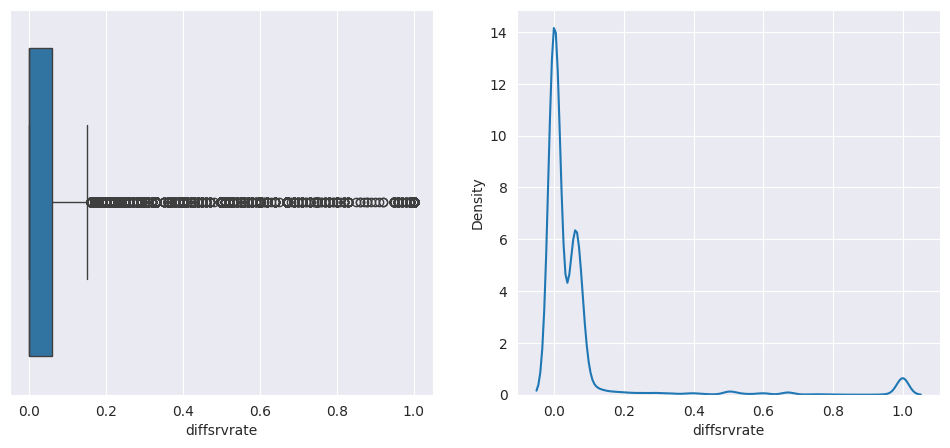

In [160]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='diffsrvrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='diffsrvrate')

In [161]:
pd.DataFrame(df['diffsrvrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
diffsrvrate,125973.0,0.063053,0.180314,0.0,0.0,0.0,0.06,1.0


In [162]:
np.percentile(df['diffsrvrate'],75),np.percentile(df['diffsrvrate'],50),np.percentile(df['diffsrvrate'],25)

(0.06, 0.0, 0.0)

In [163]:
IQR = np.percentile(df['diffsrvrate'],75)-np.percentile(df['diffsrvrate'],25)
ulimit = np.percentile(df['diffsrvrate'],75) + 1.5*IQR
ulimit

0.15

In [164]:
not_outlier = df[df['diffsrvrate'] <= ulimit]
is_outlier = df[df['diffsrvrate'] > ulimit]
total_data = df.shape[0]
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(93.81772284537163, 6.182277154628372)

In [165]:
not_outlier['is_attack'].value_counts()

,count
is_attack,
normal,64507
attack,53678


In [166]:
is_outlier['is_attack'].value_counts()

,count
is_attack,
attack,4952
normal,2836


In [167]:
# checking attacks above 50% error
df[df['diffsrvrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
attack,3289
normal,2141


In [168]:
df[df['diffsrvrate']<0.5]['is_attack'].value_counts()

,count
is_attack,
normal,65202
attack,55341


In [169]:
ddf = df.copy()
ddf['login_failed'] = ddf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
ddf['is_hot'] = ddf['hot'].apply(lambda x: 1 if x > 0 else 0)
ddf['is_compromised'] = ddf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
ddf['nroot'] = ddf['numroot'].apply(lambda x: 1 if x > 0 else 0)
ddf['fc'] = ddf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
ddf['attk'] = ddf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [171]:
# divide data into 4 bins each bin having 0.25%
ddf['bins'] = None
for i in range(len(ddf)):
  ser = ddf.loc[i,'diffsrvrate']
  if ser < 0.25:
    ddf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    ddf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    ddf.loc[i,'bins'] = 3
  else:
    ddf.loc[i,'bins'] = 4

In [172]:
ddf['bins'].value_counts()

,count
bins,
1,119158
4,3707
3,1723
2,1385


In [174]:
# number of attacks in each bin
pd.pivot_table(data=ddf,index='bins',columns='is_attack',values='attk',aggfunc='count',margins=True)

is_attack,attack,normal,All
bins,,,
1,54502,64656,119158
2,839,546,1385
3,655,1068,1723
4,2634,1073,3707
All,58630,67343,125973


In [176]:
# type of attack in each bin : bin 1
pd.pivot_table(data=ddf[ddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

bins,1,2,3,4
attack,,,,
neptune,40420.0,545.0,161.0,88.0
ipsweep,3592.0,NaN,NaN,7.0
smurf,2646.0,NaN,NaN,NaN
portsweep,2130.0,111.0,351.0,339.0
nmap,1478.0,NaN,1.0,14.0
satan,1143.0,179.0,134.0,2177.0
back,947.0,4.0,5.0,NaN
teardrop,892.0,NaN,NaN,NaN
warezclient,883.0,NaN,1.0,6.0


In [177]:
# type of attack in each bin : bin 2
pd.pivot_table(data=ddf[ddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

bins,1,2,3,4
attack,,,,
neptune,40420.0,545.0,161.0,88.0
satan,1143.0,179.0,134.0,2177.0
portsweep,2130.0,111.0,351.0,339.0
back,947.0,4.0,5.0,NaN
buffer_overflow,29.0,NaN,NaN,1.0


In [179]:
# type of attack in each bin : bin 3
pd.pivot_table(data=ddf[ddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head(7)

bins,1,2,3,4
attack,,,,
portsweep,2130.0,111.0,351.0,339.0
neptune,40420.0,545.0,161.0,88.0
satan,1143.0,179.0,134.0,2177.0
back,947.0,4.0,5.0,NaN
loadmodule,6.0,NaN,2.0,1.0
nmap,1478.0,NaN,1.0,14.0
warezclient,883.0,NaN,1.0,6.0


In [180]:
# type of attack in each bin : bin 4
pd.pivot_table(data=ddf[ddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head(7)

bins,1,2,3,4
attack,,,,
satan,1143.0,179.0,134.0,2177.0
portsweep,2130.0,111.0,351.0,339.0
neptune,40420.0,545.0,161.0,88.0
nmap,1478.0,NaN,1.0,14.0
ipsweep,3592.0,NaN,NaN,7.0
warezclient,883.0,NaN,1.0,6.0
buffer_overflow,29.0,NaN,NaN,1.0


In [185]:
# type of attack in each bin : bin 1
pd.pivot_table(data=ddf,index='service',columns='bins',values='attk',aggfunc='count',margins=True).sort_values(1,ascending=False).head(10)

bins,1,2,3,4,All
service,,,,,
All,119158.0,1385.0,1723.0,3707.0,125973
http,40132.0,122.0,52.0,32.0,40338
private,19597.0,498.0,431.0,1327.0,21853
domain_u,8868.0,44.0,64.0,67.0,9043
smtp,7013.0,16.0,40.0,244.0,7313
ftp_data,6547.0,78.0,106.0,129.0,6860
eco_i,4385.0,58.0,53.0,90.0,4586
ecr_i,3077.0,NaN,NaN,NaN,3077
other,2375.0,148.0,709.0,1127.0,4359


In [187]:
# type of attack in each bin : bin 2
pd.pivot_table(data=ddf,index='service',columns='bins',values='attk',aggfunc='count',margins=True).sort_values(2,ascending=False).head(10)

bins,1,2,3,4,All
service,,,,,
All,119158.0,1385.0,1723.0,3707.0,125973
private,19597.0,498.0,431.0,1327.0,21853
other,2375.0,148.0,709.0,1127.0,4359
http,40132.0,122.0,52.0,32.0,40338
finger,1581.0,87.0,43.0,56.0,1767
urp_i,277.0,83.0,32.0,210.0,602
ftp_data,6547.0,78.0,106.0,129.0,6860
telnet,2210.0,67.0,31.0,45.0,2353
eco_i,4385.0,58.0,53.0,90.0,4586


In [188]:
# type of attack in each bin : bin 3
pd.pivot_table(data=ddf,index='service',columns='bins',values='attk',aggfunc='count',margins=True).sort_values(3,ascending=False).head(10)

bins,1,2,3,4,All
service,,,,,
All,119158.0,1385.0,1723.0,3707.0,125973
other,2375.0,148.0,709.0,1127.0,4359
private,19597.0,498.0,431.0,1327.0,21853
ftp_data,6547.0,78.0,106.0,129.0,6860
domain_u,8868.0,44.0,64.0,67.0,9043
eco_i,4385.0,58.0,53.0,90.0,4586
http,40132.0,122.0,52.0,32.0,40338
finger,1581.0,87.0,43.0,56.0,1767
smtp,7013.0,16.0,40.0,244.0,7313


In [189]:
# type of attack in each bin : bin 4
pd.pivot_table(data=ddf,index='service',columns='bins',values='attk',aggfunc='count',margins=True).sort_values(4,ascending=False).head(10)

bins,1,2,3,4,All
service,,,,,
All,119158.0,1385.0,1723.0,3707.0,125973
private,19597.0,498.0,431.0,1327.0,21853
other,2375.0,148.0,709.0,1127.0,4359
smtp,7013.0,16.0,40.0,244.0,7313
urp_i,277.0,83.0,32.0,210.0,602
ftp_data,6547.0,78.0,106.0,129.0,6860
eco_i,4385.0,58.0,53.0,90.0,4586
domain_u,8868.0,44.0,64.0,67.0,9043
finger,1581.0,87.0,43.0,56.0,1767


In [192]:
# detailed sub binning under bin 1, find the value after which attacks rise
ddf['cbin2'] = None
for i in range(len(ddf)):
  ser = ddf.loc[i,'diffsrvrate']
  if ser < 0.05:
    ddf.loc[i,'cbin2'] = 1
  elif ser >= 0.05 and ser < 0.1:
    ddf.loc[i,'cbin2'] = 2
  elif ser >= 0.1 and ser < 0.15:
    ddf.loc[i,'cbin2'] = 3
  elif ser >= 0.15 and ser < 0.20:
    ddf.loc[i,'cbin2'] = 4
  elif ser >= 0.20 and ser < 0.25:
    ddf.loc[i,'cbin2'] = 5
  else:
    ddf.loc[i,'cbin2'] = 6

In [193]:
ddf['cbin2'].value_counts()

,count
cbin2,
1,78403
2,37928
6,6815
3,1663
4,721
5,443


In [194]:
# number of attacks across each sub bin
pd.pivot_table(data=ddf,index='cbin2',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbin2,,
1,14186,64217
2,37757,171
3,1566,97
4,637,84
5,356,87
6,4128,2687


In [195]:
df['srvdiffhostrate'].value_counts()

,count
srvdiffhostrate,
0.00,97574
1.00,8143
0.01,2865
0.50,982
0.67,975
0.12,904
0.33,790
0.02,771
0.11,732


In [196]:
df['srvdiffhostrate'].nunique()

60

<Axes: xlabel='srvdiffhostrate', ylabel='Density'>

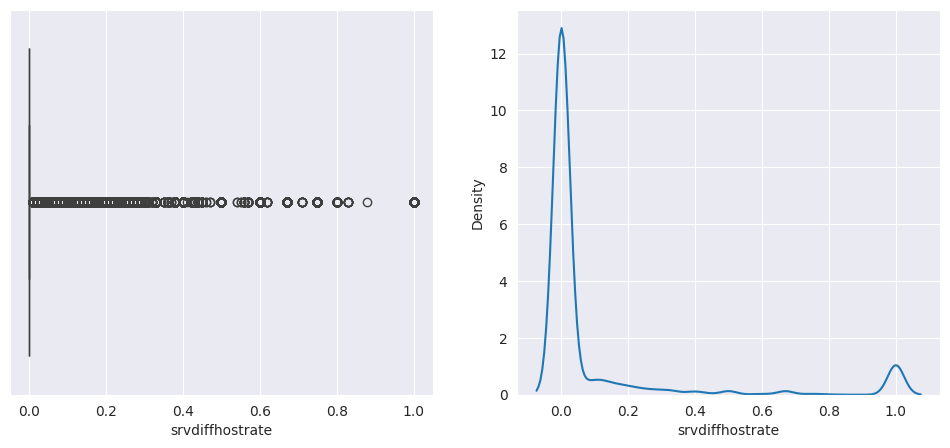

In [197]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='srvdiffhostrate')
plt.subplot(1,2,2)
sns.kdeplot(data=df,x='srvdiffhostrate')

In [198]:
pd.DataFrame(df['srvdiffhostrate'].describe()).T

,count,mean,std,min,25%,50%,75%,max
srvdiffhostrate,125973.0,0.097322,0.25983,0.0,0.0,0.0,0.0,1.0


In [200]:
np.percentile(df['srvdiffhostrate'],75),np.percentile(df['srvdiffhostrate'],50),np.percentile(df['srvdiffhostrate'],25)

(0.0, 0.0, 0.0)

In [201]:
IQR = np.percentile(df['srvdiffhostrate'],75)-np.percentile(df['srvdiffhostrate'],25)
ulimit = np.percentile(df['srvdiffhostrate'],75) + 1.5*IQR
ulimit

0.0

In [202]:
not_outlier = df[df['srvdiffhostrate'] <= ulimit]
is_outlier = df[df['srvdiffhostrate'] > ulimit]
total_data = df.shape[0]
not_outlier.shape,is_outlier.shape

((97574, 44), (28399, 44))

In [203]:
(not_outlier.shape[0]/total_data)*100, (is_outlier.shape[0]/total_data)*100

(77.45628031403555, 22.543719685964454)

In [204]:
not_outlier['is_attack'].value_counts()

,count
is_attack,
attack,54555
normal,43019


In [205]:
is_outlier['is_attack'].value_counts()

,count
is_attack,
normal,24324
attack,4075


In [206]:
# attacks when greater than 50%
df[df['srvdiffhostrate']>=0.5]['is_attack'].value_counts()

,count
is_attack,
normal,6863
attack,3783


In [207]:
# attacks when greater than 50%
df[df['srvdiffhostrate']<=0.5]['is_attack'].value_counts()

,count
is_attack,
normal,61357
attack,54952


In [208]:
sddf = df.copy()
sddf['login_failed'] = sddf['numfailedlogins'].apply(lambda x: 0 if x == 0 else 1)
sddf['is_hot'] = sddf['hot'].apply(lambda x: 1 if x > 0 else 0)
sddf['is_compromised'] = sddf['numcompromised'].apply(lambda x: 1 if x > 0 else 0)
sddf['nroot'] = sddf['numroot'].apply(lambda x: 1 if x > 0 else 0)
sddf['fc'] = sddf['numfilecreations'].apply(lambda x: 1 if x > 0 else 0)
sddf['attk'] = sddf['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [209]:
# bin the data into 4 groups
sddf['bins'] = None
for i in range(len(sddf)):
  ser = sddf.loc[i,'srvdiffhostrate']
  if ser < 0.25:
    sddf.loc[i,'bins'] = 1
  elif ser >= 0.25 and ser < 0.5:
    sddf.loc[i,'bins'] = 2
  elif ser >= 0.5 and ser < 0.75:
    sddf.loc[i,'bins'] = 3
  else:
    sddf.loc[i,'bins'] = 4

In [210]:
sddf['bins'].value_counts()

,count
bins,
1,111577
4,8446
2,3750
3,2200


In [211]:
# number of attacks across each bin
pd.pivot_table(data=sddf,index='bins',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
bins,,
1,54716,56861
2,131,3619
3,219,1981
4,3564,4882


In [217]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(1,ascending=False).head()

bins,1,2,3,4
attack,,,,
neptune,41145.0,34.0,22.0,13.0
satan,3624.0,NaN,4.0,5.0
portsweep,2925.0,1.0,1.0,4.0
smurf,2646.0,NaN,NaN,NaN
ipsweep,1066.0,1.0,NaN,2532.0


In [220]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

bins,1,2,3,4
attack,,,,
back,750.0,86.0,89.0,31.0
neptune,41145.0,34.0,22.0,13.0
imap,3.0,8.0,NaN,NaN
ipsweep,1066.0,1.0,NaN,2532.0
portsweep,2925.0,1.0,1.0,4.0


In [221]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(3,ascending=False).head()

bins,1,2,3,4
attack,,,,
pod,99.0,NaN,101.0,1.0
back,750.0,86.0,89.0,31.0
neptune,41145.0,34.0,22.0,13.0
satan,3624.0,NaN,4.0,5.0
warezclient,877.0,1.0,2.0,10.0


In [216]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='bins',values='attk',aggfunc='count').sort_values(4,ascending=False).head()

bins,1,2,3,4
attack,,,,
ipsweep,1066.0,1.0,NaN,2532.0
nmap,542.0,NaN,NaN,951.0
back,750.0,86.0,89.0,31.0
land,4.0,NaN,NaN,14.0
neptune,41145.0,34.0,22.0,13.0


In [222]:
# detailed sub binning under bin 1, find the value after which attacks rise
sddf['cbin2'] = None
for i in range(len(sddf)):
  ser = sddf.loc[i,'srvdiffhostrate']
  if ser < 0.05:
    sddf.loc[i,'cbin2'] = 1
  elif ser >= 0.05 and ser < 0.1:
    sddf.loc[i,'cbin2'] = 2
  elif ser >= 0.1 and ser < 0.15:
    sddf.loc[i,'cbin2'] = 3
  elif ser >= 0.15 and ser < 0.20:
    sddf.loc[i,'cbin2'] = 4
  elif ser >= 0.20 and ser < 0.25:
    sddf.loc[i,'cbin2'] = 5
  else:
    sddf.loc[i,'cbin2'] = 6

In [223]:
sddf['cbin2'].value_counts()

,count
cbin2,
1,101615
6,14396
3,3491
2,2635
4,2260
5,1576


In [224]:
# number of attacks across each sub bin
pd.pivot_table(data=sddf,index='cbin2',columns='is_attack',values='attk',aggfunc='count')

is_attack,attack,normal
cbin2,,
1,54555,47060
2,26,2609
3,74,3417
4,42,2218
5,19,1557
6,3914,10482


In [228]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(1,ascending=False).head(10)

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,40992.0,26.0,72.0,36.0,19.0,69.0
satan,3624.0,NaN,NaN,NaN,NaN,9.0
portsweep,2925.0,NaN,NaN,NaN,NaN,6.0
smurf,2646.0,NaN,NaN,NaN,NaN,NaN
ipsweep,1066.0,NaN,NaN,NaN,NaN,2533.0
teardrop,892.0,NaN,NaN,NaN,NaN,NaN
warezclient,876.0,NaN,1.0,NaN,NaN,13.0
back,743.0,NaN,1.0,6.0,NaN,206.0
nmap,542.0,NaN,NaN,NaN,NaN,951.0


In [230]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(2,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,40992.0,26.0,72.0,36.0,19.0,69.0
back,743.0,NaN,1.0,6.0,NaN,206.0
buffer_overflow,30.0,NaN,NaN,NaN,NaN,NaN
ftp_write,7.0,NaN,NaN,NaN,NaN,1.0
guess_passwd,53.0,NaN,NaN,NaN,NaN,NaN


In [231]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(3,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,40992.0,26.0,72.0,36.0,19.0,69.0
back,743.0,NaN,1.0,6.0,NaN,206.0
warezclient,876.0,NaN,1.0,NaN,NaN,13.0
buffer_overflow,30.0,NaN,NaN,NaN,NaN,NaN
ftp_write,7.0,NaN,NaN,NaN,NaN,1.0


In [232]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(4,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,40992.0,26.0,72.0,36.0,19.0,69.0
back,743.0,NaN,1.0,6.0,NaN,206.0
buffer_overflow,30.0,NaN,NaN,NaN,NaN,NaN
ftp_write,7.0,NaN,NaN,NaN,NaN,1.0
guess_passwd,53.0,NaN,NaN,NaN,NaN,NaN


In [233]:
pd.pivot_table(data=sddf[sddf['attack'] != 'normal'],index='attack',columns='cbin2',values='attk',aggfunc='count').sort_values(5,ascending=False).head()

cbin2,1,2,3,4,5,6
attack,,,,,,
neptune,40992.0,26.0,72.0,36.0,19.0,69.0
back,743.0,NaN,1.0,6.0,NaN,206.0
buffer_overflow,30.0,NaN,NaN,NaN,NaN,NaN
ftp_write,7.0,NaN,NaN,NaN,NaN,1.0
guess_passwd,53.0,NaN,NaN,NaN,NaN,NaN
